# Temporally Dependent TV/TGV Regularisation

## Training Script

1. Loading inputs and labels
2. Partitioning in training and validation data 
3. Visualization of a sample
4. Defining the models
5. Loss function and optimizer
6. Training loop
7. Results

In [16]:
# Imports
import sys
import torch
from datetime import datetime
sys.path.append("/home/jovyan/P1-Temp-Reg/nns_based_approach")
from cnn_blocks.unet import UNet
from utilities.dataset import ImageDataset
from utilities.plot import animated_imshow
from tv_recon_network.network import LearnedTVMapCNN
import matplotlib.pyplot as plt
import numpy as np

In [17]:
data_path = "/home/jovyan/data/"
valid_fraction = 0.2

dataset = ImageDataset(input_data_path=f"{data_path}input_data/", 
                       label_data_path=f"{data_path}label_data/")

train_set_len = int((1-valid_fraction)*len(dataset))
dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [train_set_len, len(dataset)-train_set_len])

print(f"Total: {len(dataset)}\nTraining: {len(dataset_train)}\nValidation: {len(dataset_valid)}")

Total: 488
Training: 390
Validation: 98


In [18]:
# Parameters
epochs = 100
n_batch = 1
learning_rate = 1e-4

In [19]:
# Define data loaders
train = torch.utils.data.DataLoader(dataset_train, batch_size=n_batch, shuffle=True)
valid = torch.utils.data.DataLoader(dataset_valid, batch_size=n_batch, shuffle=False)

In [20]:
# Visualize the data
data, label, model = dataset_valid[20]
animated_imshow(label[0, ...])

Started reading acquisitions from /home/jovyan/data/input_data/y_149.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..99%..
Finished reading acquisitions from /home/jovyan/data/input_data/y_149.h5


## Data Format

- `data` is a SIRF AcquisitionData object, time and readout dimensions are mixed in array dimension 0 due to call `as_array()`
- `label` is a nifti image
- `model` is a SIRF AcquisitionModel object 

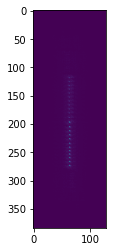

In [21]:
plt.imshow(np.abs(data.as_array()[:, 0, :]))
plt.show()

In [22]:
# Define the model
unet = UNet(dim=3, 
          n_ch_in=2, 
          n_ch_out=2, 
          n_enc_stages=3,
          n_convs_per_stage=2, 
          n_filters=16,
          kernel_size=3, 
          res_connection=True,
          bias=True)

print(unet)

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (2): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride

In [23]:
tv = LearnedTVMapCNN(unet, T=1)
# print(tv)

# test = tv(data, model)

In [24]:
# Loss function
class mse_loss(torch.nn.Module):
    def __init__(self):
        super(mse_loss, self).__init__()
        self.mse = torch.nn.MSELoss()
    def forward(self, model, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        x_nn, = model(x)
        return self.mse(x_nn.float(), y.float())

# Optimizer
optimizer = torch.optim.Adam(tv.parameters(), lr=learning_rate)

In [25]:
# Define training routine for one batch
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels, = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = mse_loss(nn, outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [32]:
# TRAINING LOOP

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = torch.utils.tensorboard.SummaryWriter('/home/jovyan/runs/trainer_{}'.format(timestamp))
epoch_number = 0

exit()

for epoch in range(epochs):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


AttributeError: 'AcquisitionModel' object has no attribute 'train'

datetime.datetime(2022, 3, 18, 14, 50, 9, 899436)